In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

In [2]:
data = pd.read_csv("./arrests.csv")

In [3]:
nulos_por_columna = data.isnull().sum()
print(nulos_por_columna)

ARREST_KEY               0
ARREST_DATE              0
PD_CD                  313
PD_DESC               9169
KY_CD                 9169
OFNS_DESC             9169
LAW_CODE               196
LAW_CAT_CD           20254
ARREST_BORO              8
ARREST_PRECINCT          0
JURISDICTION_CODE       10
AGE_GROUP               17
PERP_SEX                 0
PERP_RACE                0
X_COORD_CD               1
Y_COORD_CD               1
Latitude                 1
Longitude                1
Lon_Lat                  1
dtype: int64


In [4]:
# Convertir ARREST_DATE al formato datetime
data['ARREST_DATE'] = pd.to_datetime(data['ARREST_DATE'])

# Obtener fechas mínima y máxima
min_date = data['ARREST_DATE'].min()
max_date = data['ARREST_DATE'].max()

# Mes del arresto
data['Month'] = data['ARREST_DATE'].dt.strftime('%B')

# Día de la semana del arresto
data['Day'] = data['ARREST_DATE'].dt.day_name()

In [5]:
# Renombrar columnas
data.rename(columns={
    'ARREST_BORO': 'Borough',
    'PERP_SEX': 'Sex',
    'PERP_RACE': 'Race',
    'JURISDICTION_CODE': 'Jurisdiction',
    'ARREST_DATE': 'Date',
    'ARREST_PRECINCT': 'Precint',
    'LAW_CAT_CD': 'Category',
    'AGE_GROUP': 'Age',
    'OFNS_DESC': 'Description',
    'LAW_CODE': 'Law',
    'ARREST_KEY': 'ID'
}, inplace=True)


In [6]:
# Filtrar filas con valores no nulos en Latitude y Longitude
data = data[data['Latitude'].notna()]
data = data[data['Longitude'].notna()]

In [7]:
# Reemplazar códigos de Borough por nombres
data['Borough'] = data['Borough'].replace({
    'B': 'Bronx',
    'S': 'Staten Island',
    'K': 'Brooklyn',
    'M': 'Manhattan',
    'Q': 'Queens'
}).fillna('Unknown')

# Agrupar por Borough y contar
borough_counts = data.groupby('Borough').size().reset_index(name='count')

In [8]:
# Reemplazar códigos de Jurisdiction
data['Jurisdiction'] = data['Jurisdiction'].replace({
    0: 'Patrol',
    1: 'Transit',
    2: 'Housing'
}).fillna('Other')

# Reemplazar códigos de Category
data['Category'] = data['Category'].replace({
    'F': 'Felony',
    'M': 'Misdemeanor',
    'V': 'Violation',
    'I': 'Infraction'
}).fillna('Unknown')

# Agrupar por Category y contar
category_counts = data.groupby('Category').size().reset_index(name='count')

# Agrupar por Race y contar
race_counts = data.groupby('Race').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [9]:
# Imputar valores faltantes en Race
data['Race'] = np.where(
    data['Race'].isin([
        'AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER',
        'BLACK', 'BLACK HISPANIC', 'OTHER', 'WHITE', 'WHITE HISPANIC'
    ]),
    data['Race'],
    'BLACK'
)

In [10]:
# Agrupar por Age y contar
age_counts = data.groupby('Age').size().reset_index(name='count').sort_values(by='count', ascending=False)
copia = data.copy()
copia['Age'] = np.where(
    copia['Age'].isin(['<18', '18-24', '25-44', '45-64', '65+']),
    'No missing',
    'Missing')

# Código de ofensa con más valores "Missing" en Age
missing_age_mode = (
    copia[copia['Age'] == 'Missing']
    .groupby('KY_CD')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .iloc[0]['KY_CD']
)

# Imputar valores faltantes en Age
data['Age'] = np.where(
    data['Age'].isin(['<18', '18-24', '25-44', '45-64', '65+']),
    data['Age'],
    '25-44'
)

In [11]:
# Imputar valores faltantes en KY_CD
data['KY_CD'] = data['KY_CD'].fillna(235)

In [12]:
# Eliminar registros con nulos en cualquier columna
data = data.dropna()

# Reiniciar el índice después de eliminar registros
data = data.reset_index(drop=True)

In [13]:
##OUTLIERS 

# Dividir el DataFrame en dos: outliers y no outliers según Latitude
outliers_lat = data[data['Latitude'] > 41]
no_outliers_lat = data[data['Latitude'] <= 41]

# Calcular la mediana de Latitude para cada Borough
borough_medians = data.groupby('Borough')['Latitude'].median()

# Imputar los valores outliers con la mediana de Latitude según Borough
outliers_lat['Latitude'] = outliers_lat['Borough'].map(borough_medians)

# Asegurarse de que Latitude es numérica
outliers_lat['Latitude'] = pd.to_numeric(outliers_lat['Latitude'])

# Concatenar nuevamente los DataFrames
data = pd.concat([outliers_lat, no_outliers_lat])


C:\Users\peric\AppData\Local\Temp\ipykernel_156\2586682612.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_lat['Latitude'] = outliers_lat['Borough'].map(borough_medians)
C:\Users\peric\AppData\Local\Temp\ipykernel_156\2586682612.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_lat['Latitude'] = pd.to_numeric(outliers_lat['Latitude'])


In [14]:
data.dtypes

ID                       int64
Date            datetime64[ns]
PD_CD                  float64
PD_DESC                 object
KY_CD                  float64
Description             object
Law                     object
Category                object
Borough                 object
Precint                  int64
Jurisdiction            object
Age                     object
Sex                     object
Race                    object
X_COORD_CD             float64
Y_COORD_CD             float64
Latitude               float64
Longitude              float64
Lon_Lat                 object
Month                   object
Day                     object
dtype: object

NOTEBOOK 1 - ONE HOT ENCODER

In [15]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Make a copy of the original data
df = data.copy()

# Specify categorical columns y Convertir los valores numéricos en 'Jurisdiction' a strings
df['Jurisdiction'] = df['Jurisdiction'].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)
categorical_columns = ['Category', 'Borough', 'Jurisdiction', 'Age', 'Sex', 'Race']


encoder = OneHotEncoder(sparse_output=False, drop='first')

categorical_encoded = pd.DataFrame(
    encoder.fit_transform(df[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns),
    index=df.index
)

data = pd.concat([data.drop(columns=categorical_columns), categorical_encoded], axis=1)


In [16]:
numerical_columns = ['Law','Precint', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude','Day','Month']
data[numerical_columns] = data[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [17]:
data.columns

Index(['ID', 'Date', 'PD_CD', 'PD_DESC', 'KY_CD', 'Description', 'Law',
       'Precint', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lon_Lat', 'Month', 'Day', 'Category_Infraction',
       'Category_Misdemeanor', 'Category_Unknown', 'Category_Violation',
       'Borough_Brooklyn', 'Borough_Manhattan', 'Borough_Queens',
       'Borough_Staten Island', 'Borough_Unknown', 'Jurisdiction_12.0',
       'Jurisdiction_13.0', 'Jurisdiction_14.0', 'Jurisdiction_15.0',
       'Jurisdiction_16.0', 'Jurisdiction_3.0', 'Jurisdiction_4.0',
       'Jurisdiction_6.0', 'Jurisdiction_69.0', 'Jurisdiction_7.0',
       'Jurisdiction_71.0', 'Jurisdiction_72.0', 'Jurisdiction_73.0',
       'Jurisdiction_74.0', 'Jurisdiction_76.0', 'Jurisdiction_79.0',
       'Jurisdiction_8.0', 'Jurisdiction_82.0', 'Jurisdiction_85.0',
       'Jurisdiction_87.0', 'Jurisdiction_88.0', 'Jurisdiction_9.0',
       'Jurisdiction_97.0', 'Jurisdiction_Housing', 'Jurisdiction_Other',
       'Jurisdiction_Patrol', '

NOTEBOOK 2 - VARIABLES CICLICAS (seno y coseno)

In [18]:
pip install pycircular

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


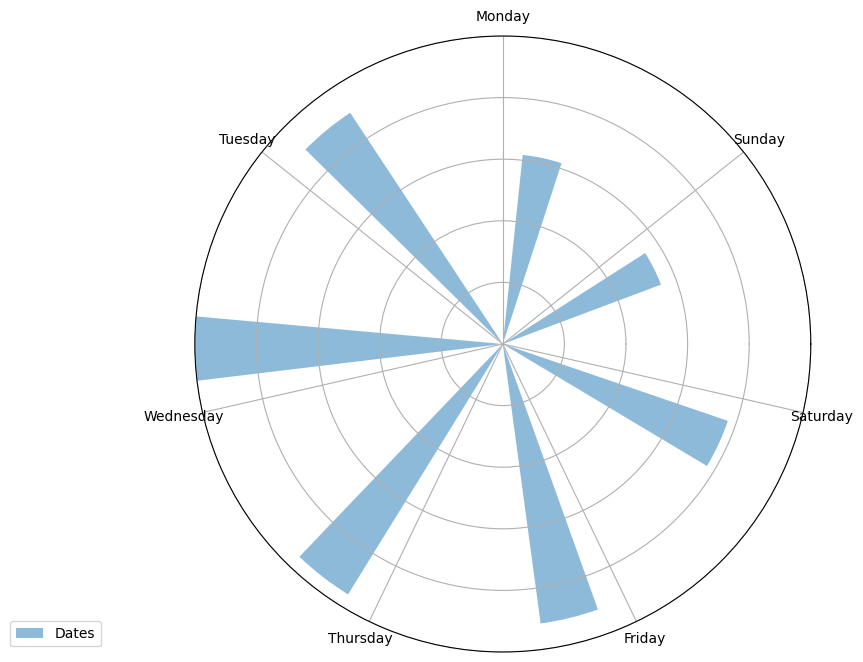

In [19]:
import pycircular
import matplotlib.pyplot as plt

time_segment = 'dayweek'  
freq_arr, times = pycircular.utils.freq_time(data['Date'] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

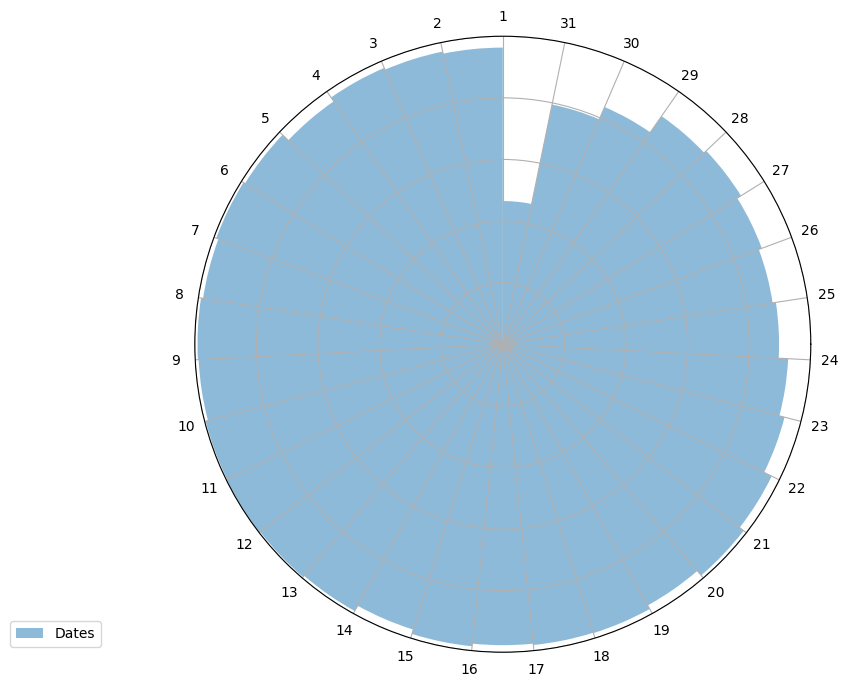

In [20]:
time_segment = 'daymonth'  
freq_arr, times = pycircular.utils.freq_time(data['Date'] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

In [21]:
import numpy as np
import pandas as pd

# Asegúrate de que la columna "Date" esté en formato datetime
data['Date'] = pd.to_datetime(data['Date'])

# Extraer el día del año (1-365 o 1-366)
data['day_of_year'] = data['Date'].dt.dayofyear

# Generar las variables seno y coseno
data['sin_day'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
data['cos_day'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

# Si trabajas con años bisiestos, puedes ajustar el cálculo para 366 días


NOTEBOOK 4 - BAYESIANA Y PIPELINES

NOTEBOOK 5  -SHAP

NOTEBOOK 6 - METRICAS AVANZADAS

notebook 7 - GIS

MAPA TIENE QUE IR ARRIBA DEL ONE HOT ENCOEDER

notebook 8 - todo
- nico peric (randomwalk)
- falta hacer: media constante, tendencia lineal, tendencia cuadratica, logaeritmica, estaciobalidad mensual, media movil, exponential smoothing, 

In [23]:
data

,ID,Date,PD_CD,PD_DESC,KY_CD,Description,Law,Precint,X_COORD_CD,Y_COORD_CD,...,Sex_M,Race_ASIAN / PACIFIC ISLANDER,Race_BLACK,Race_BLACK HISPANIC,Race_OTHER,Race_WHITE,Race_WHITE HISPANIC,day_of_year,sin_day,cos_day
217147,85594383,2012-07-05,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,NaN,25,1003300.0,5230799.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,187,-0.077386,-0.997001
217218,84747924,2012-05-15,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,NaN,40,1007098.0,3234465.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,136,0.717677,-0.696376
217280,84164045,2012-04-11,203.0,"TRESPASS 3, CRIMINAL",352.0,CRIMINAL TRESPASS,NaN,47,1027676.0,2261851.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,102,0.982927,-0.183998
217424,82437256,2012-01-02,397.0,"ROBBERY,UNCLASSIFIED,OPEN AREAS",105.0,ROBBERY,NaN,52,1013626.0,3253434.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2,0.034422,0.999407
217431,82300383,2011-12-22,782.0,"WEAPONS, POSSESSION, ETC",236.0,DANGEROUS WEAPONS,NaN,47,1027676.0,2261851.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,356,-0.154309,0.988023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5299701,223362860,2021-01-21,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,NaN,75,1014484.0,181357.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,21,0.353676,0.935368
5299702,223538337,2021-01-25,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",113.0,FORGERY,NaN,67,1003422.0,178505.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,25,0.417194,0.908818
5299703,222833413,2021-01-09,779.0,"PUBLIC ADMINISTRATION,UNCLASSI",126.0,MISCELLANEOUS PENAL LAW,NaN,18,988211.0,218129.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,9,0.154309,0.988023
5299704,224017670,2021-02-05,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,NaN,43,1020183.0,239283.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,36,0.580800,0.814046


In [28]:
data['Date'] = pd.to_datetime(data['Date'])  # Asegurarse de que sea datetime
cantidad_por_dia = data.groupby(data['Date'].dt.to_period('D')).size().reset_index(name='Cantidad')

In [29]:
cantidad_por_dia

,Date,Cantidad
0,2006-01-01,551
1,2006-01-02,618
2,2006-01-03,899
3,2006-01-04,1229
4,2006-01-05,1383
...,...,...
5839,2021-12-27,297
5840,2021-12-28,358
5841,2021-12-29,366
5842,2021-12-30,325


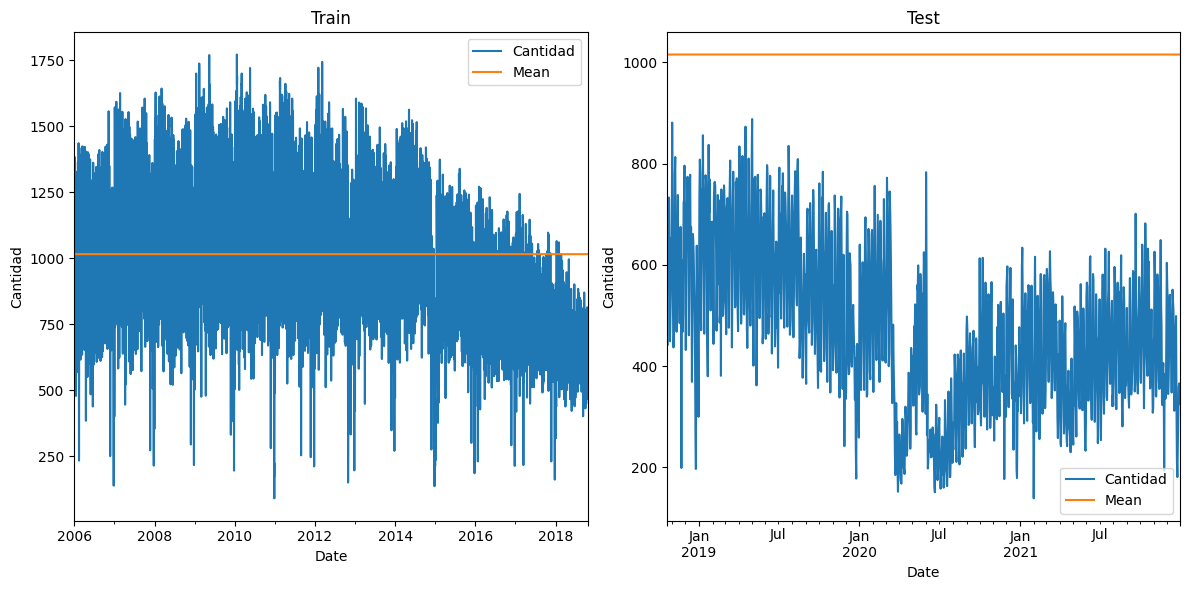

  Model        RMSE
0  Mean  564.612685


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Crear la columna 'Cantidad' como el conteo de arrestos por día
data['Date'] = pd.to_datetime(data['Date'])  # Asegurarse de que sea datetime
cantidad_por_dia = data.groupby('Date').size().reset_index(name='Cantidad')

# Dividir los datos en train y test (80%-20%), sin mezclar (shuffle=False)
df_train, df_test = train_test_split(cantidad_por_dia, test_size=0.2, shuffle=False, random_state=42)

# Calcular la media de la columna 'Cantidad' en el dataset de entrenamiento
model_mean_pred = df_train['Cantidad'].mean()

# Añadir la predicción basada en la media al DataFrame de train y test
df_train_mc = df_train.copy()
df_train_mc['Mean'] = model_mean_pred

df_test_mc = df_test.copy()
df_test_mc['Mean'] = model_mean_pred

# Graficar los datos reales y las predicciones de la media
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df_train_mc.plot(ax=axes[0], x='Date', y=["Cantidad", "Mean"], title="Train", legend=True)
axes[0].set_ylabel("Cantidad")

df_test_mc.plot(ax=axes[1], x='Date', y=["Cantidad", "Mean"], title="Test", legend=True)
axes[1].set_ylabel("Cantidad")

plt.tight_layout()
plt.show()

# Calcular el RMSE entre las predicciones y los valores reales en el test set
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

model_RMSE = RMSE(df_test_mc['Cantidad'], df_test_mc['Mean'])

# Registrar los resultados en un DataFrame
df_Results = pd.DataFrame(columns=["Model", "RMSE"])
df_Results.loc[0] = ["Mean", model_RMSE]

# Mostrar los resultados
print(df_Results)

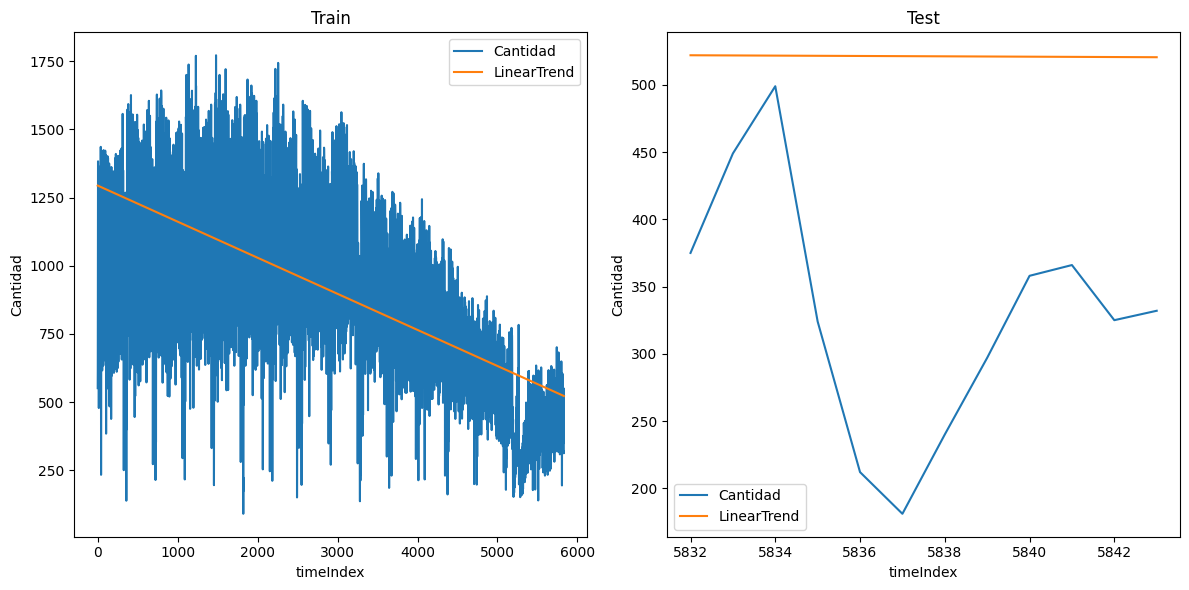

         Model        RMSE
0         Mean  564.612685
1  LinearTrend  210.527117


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Crear la columna 'Cantidad' como el conteo de arrestos por día
data['Date'] = pd.to_datetime(data['Date'])  # Asegurarse de que sea datetime
cantidad_por_dia = data.groupby('Date').size().reset_index(name='Cantidad')

# Crear un índice temporal para el modelo de tendencia lineal
cantidad_por_dia["timeIndex"] = np.arange(len(cantidad_por_dia))

# Dividir los datos en train y test (últimos 12 días para test)
df_train, df_test = train_test_split(cantidad_por_dia, test_size=12, random_state=42, shuffle=False)

# Ajustar un modelo de regresión lineal a los datos de entrenamiento
model_linear = smf.ols(formula='Cantidad ~ timeIndex', data=df_train).fit()

# Generar las predicciones para los conjuntos de train y test
df_train["LinearTrend"] = model_linear.predict(df_train.timeIndex)
df_test["LinearTrend"] = model_linear.predict(df_test.timeIndex)

# Graficar los resultados
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
df_train.plot(kind="line", x="timeIndex", y=["Cantidad", "LinearTrend"], ax=axes[0], title='Train')
axes[0].set_ylabel("Cantidad")

df_test.plot(kind="line", x="timeIndex", y=["Cantidad", "LinearTrend"], ax=axes[1], title='Test')
axes[1].set_ylabel("Cantidad")

plt.tight_layout()
plt.show()

# Calcular el RMSE para el modelo de tendencia lineal
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

model_RMSE = RMSE(df_test["Cantidad"], df_test["LinearTrend"])

# Registrar los resultados en el DataFrame de resultados
df_Results.loc[1] = ["LinearTrend", model_RMSE]

# Mostrar los resultados
print(df_Results)


In [ ]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Cantidad   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     3898.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:22:41   Log-Likelihood:                -40980.
No. Observations:                5832   AIC:                         8.196e+04
Df Residuals:                    5830   BIC:                         8.198e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1293.9382      7.138    181.286      0.000    1279.946    1307.930
timeIndex     -0.1324      0.002    -62.431      0.000      -0.137      -0.128
==============================================================================
Omnibus:                       41.940   Durbin-Watson:                   0.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.097
Skew:                          -0.175   Prob(JB):                     1.96e-09
Kurtosis:                       2.795   Cond. No.                     6.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

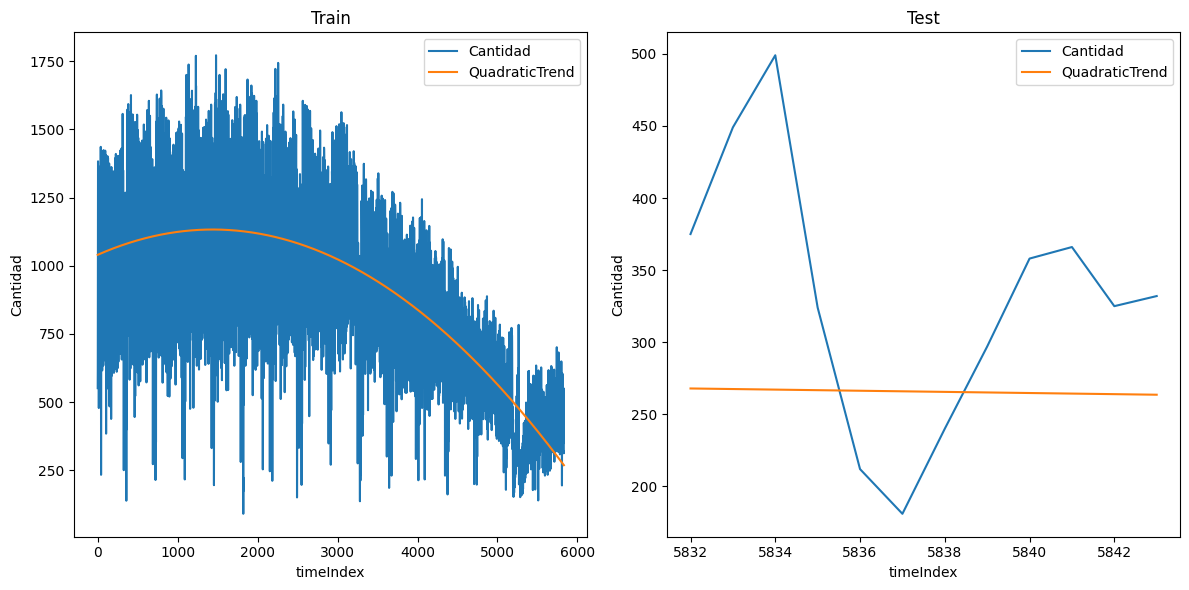

                            OLS Regression Results                            
Dep. Variable:               Cantidad   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     2971.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:22:41   Log-Likelihood:                -40423.
No. Observations:                5832   AIC:                         8.085e+04
Df Residuals:                    5829   BIC:                         8.087e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1040.0839      9.731    106.885   

In [ ]:
# Crear columna de tendencia cuadrática
cantidad_por_dia["timeIndex_sq"] = cantidad_por_dia["timeIndex"] ** 2

# Dividir los datos en entrenamiento y prueba (últimos 12 días para test)
df_train, df_test = train_test_split(cantidad_por_dia, test_size=12, random_state=42, shuffle=False)

# Ajustar el modelo cuadrático
model_quadratic = smf.ols('Cantidad ~ timeIndex + timeIndex_sq', data=df_train).fit()

# Generar predicciones para el conjunto de entrenamiento y prueba
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex", "timeIndex_sq"]])
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex", "timeIndex_sq"]])

# Graficar resultados
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
df_train.plot(kind="line", x="timeIndex", y=["Cantidad", "QuadraticTrend"], ax=axes[0], title='Train')
axes[0].set_ylabel("Cantidad")

df_test.plot(kind="line", x="timeIndex", y=["Cantidad", "QuadraticTrend"], ax=axes[1], title='Test')
axes[1].set_ylabel("Cantidad")

plt.tight_layout()
plt.show()

# Calcular RMSE para el modelo cuadrático
model_RMSE = RMSE(df_test["Cantidad"], df_test["QuadraticTrend"])

# Registrar los resultados en el DataFrame de resultados
df_Results.loc[2] = ["QuadraticTrend", model_RMSE]

# Mostrar el resumen del modelo
print(model_quadratic.summary())

# Mostrar los resultados
print(df_Results)


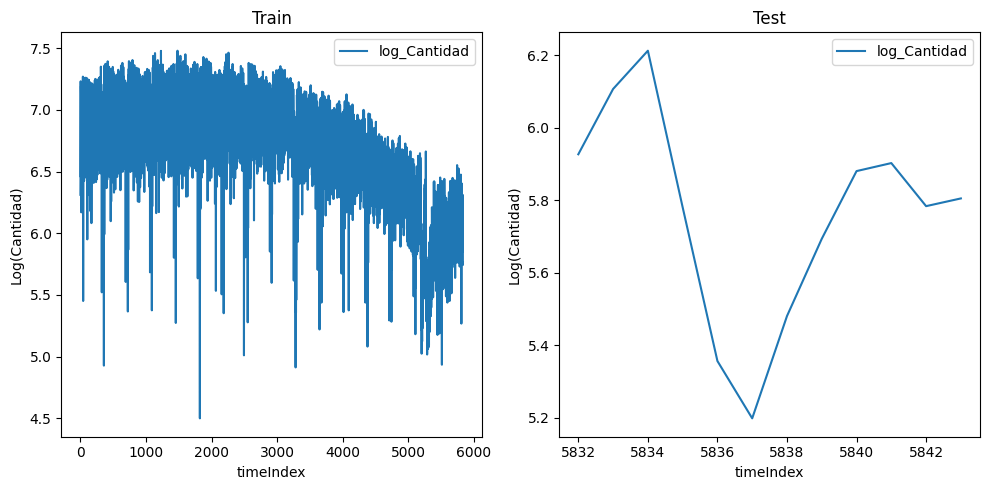

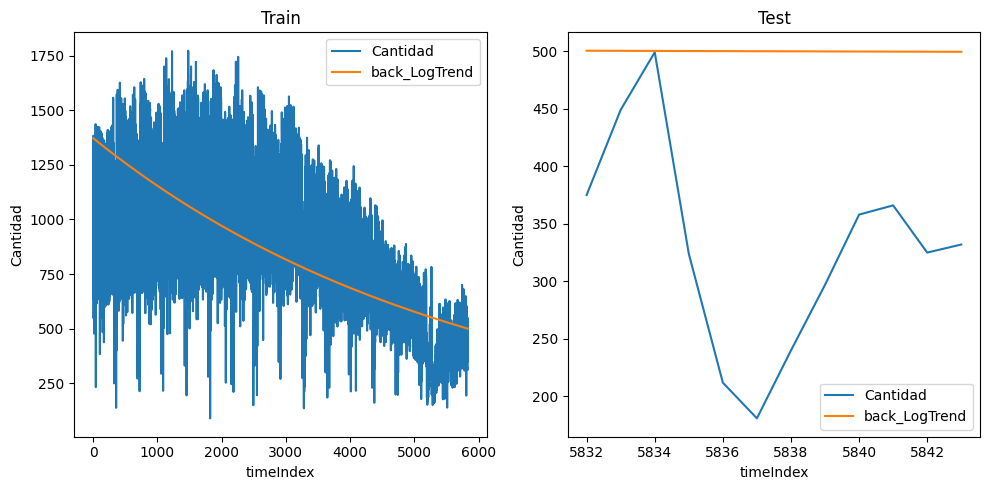

                            OLS Regression Results                            
Dep. Variable:           log_Cantidad   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     3973.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:22:42   Log-Likelihood:                -2198.1
No. Observations:                5832   AIC:                             4400.
Df Residuals:                    5830   BIC:                             4414.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2240      0.009    781.965      0.0

In [ ]:
# Transformación logarítmica de la variable objetivo
df_train['log_Cantidad'] = np.log(df_train['Cantidad'])
df_test['log_Cantidad'] = np.log(df_test['Cantidad'])

# Graficar la transformación logarítmica
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
df_train.plot(kind="line", x="timeIndex", y=["log_Cantidad"], ax=axes[0], title='Train')
axes[0].set_ylabel("Log(Cantidad)")

df_test.plot(kind="line", x="timeIndex", y=["log_Cantidad"], ax=axes[1], title='Test')
axes[1].set_ylabel("Log(Cantidad)")

plt.tight_layout()
plt.show()

# Ajustar el modelo logarítmico
model_log = smf.ols('log_Cantidad ~ timeIndex', data=df_train).fit()

# Predicción de la tendencia logarítmica
df_train["LogTrend"] = model_log.predict(df_train[["timeIndex"]])
df_test["LogTrend"] = model_log.predict(df_test[["timeIndex"]])

# Transformar las predicciones de vuelta al espacio original
df_train['back_LogTrend'] = np.exp(df_train['LogTrend'])
df_test['back_LogTrend'] = np.exp(df_test['LogTrend'])

# Graficar las predicciones en el espacio original
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
df_train.plot(kind="line", x="timeIndex", y=["Cantidad", "back_LogTrend"], ax=axes[0], title='Train')
axes[0].set_ylabel("Cantidad")

df_test.plot(kind="line", x="timeIndex", y=["Cantidad", "back_LogTrend"], ax=axes[1], title='Test')
axes[1].set_ylabel("Cantidad")

plt.tight_layout()
plt.show()

# Calcular RMSE para las predicciones transformadas
model_RMSE = RMSE(df_test["back_LogTrend"], df_test["Cantidad"])

# Registrar los resultados en el DataFrame de resultados
df_Results.loc[3] = ["LogTrend (Back Transformed)", model_RMSE]

# Mostrar el resumen del modelo logarítmico
print(model_log.summary())

# Mostrar los resultados
print(df_Results)


In [ ]:
# Crear columna con el mes (abreviado)
df_train['month'] = df_train['Date'].dt.strftime('%b')
df_test['month'] = df_test['Date'].dt.strftime('%b')

In [ ]:
# Generar las dummies correctamente
dummies_mes_train = pd.get_dummies(df_train['month'], drop_first=True)
dummies_mes_test = pd.get_dummies(df_test['month'], drop_first=True)

# Añadir las dummies al DataFrame
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)

# Verificar las columnas generadas
print(df_train.columns)

Index(['Date', 'Cantidad', 'timeIndex', 'timeIndex_sq', 'QuadraticTrend',
       'log_Cantidad', 'LogTrend', 'back_LogTrend', 'month', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')


In [ ]:
# Verificar las primeras filas del DataFrame
print(df_train.head(4))

# Ajustar el modelo con la tendencia logarítmica y las dummies de mes
formula = 'log_Cantidad ~ timeIndex + ' + ' + '.join(dummies_mes_train.columns)

# Ajustar el modelo
model_log_est = smf.ols(formula, data=df_train).fit()

# Verificar el modelo
print(model_log_est.summary())



        Date  Cantidad  timeIndex  timeIndex_sq  QuadraticTrend  log_Cantidad  \
0 2006-01-01       551          0             0     1040.083908      6.311735   
1 2006-01-02       618          1             1     1040.212763      6.426488   
2 2006-01-03       899          2             4     1040.341527      6.801283   
3 2006-01-04      1229          3             9     1040.470202      7.113956   

   LogTrend  back_LogTrend month    Aug    Dec    Feb   Jan    Jul    Jun  \
0  7.223996    1371.960907   Jan  False  False  False  True  False  False   
1  7.223823    1371.723641   Jan  False  False  False  True  False  False   
2  7.223650    1371.486415   Jan  False  False  False  True  False  False   
3  7.223477    1371.249231   Jan  False  False  False  True  False  False   

     Mar    May    Nov    Oct    Sep  
0  False  False  False  False  False  
1  False  False  False  False  False  
2  False  False  False  False  False  
3  False  False  False  False  False  
             

notebook 9 - todo

notebook 10,11 y 12 son sistemas de recomendacion asi que no tenemos que usar

notebook 13 - probar alguna red neuronal

In [ ]:
# Calcular el número de arrestos por día
arrestos_por_dia = data.groupby('Date').size()

# Crear una nueva columna 'Cantidad' con el número de arrestos por día
data['Cantidad'] = data['Date'].map(arrestos_por_dia)


In [ ]:
# Ahora, para las medias móviles
data["sma_5"] = data['Cantidad'].rolling(5, min_periods=1).mean()  # Media móvil de 5 días
data["sma_15"] = data['Cantidad'].rolling(15, min_periods=1).mean()  # Media móvil de 15 días

In [ ]:
import matplotlib.pyplot as plt

# Aumentar el tamaño de los bloques de celdas para evitar el error
plt.rcParams['agg.path.chunksize'] = 10000  # Ajusta este valor según sea necesario

# Graficar la serie de tiempo y las medias móviles
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Cantidad'], label='Cantidad por día', color='blue', alpha=0.6)
plt.plot(data['Date'], data['sma_5'], label='SMA 5 días', color='orange', linestyle='--')
plt.plot(data['Date'], data['sma_15'], label='SMA 15 días', color='green', linestyle='--')
plt.title('Cantidad por día con Medias Móviles (5 y 15 días)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

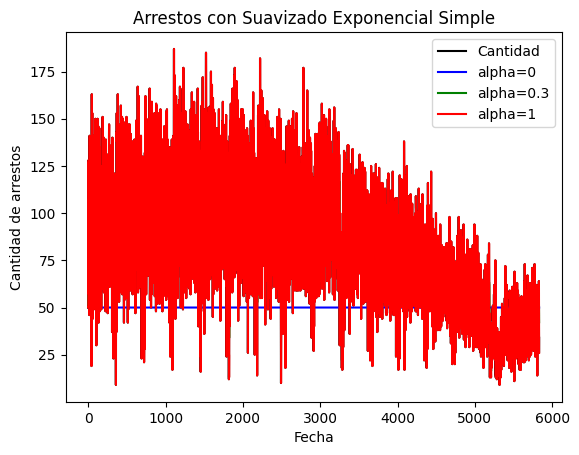

,Model,RMSE
0,Mean,53.756740
1,LinearTrend,22.879905
2,QuadraticTrend,12.225214
3,LogTrend (Back Transformed),20.674903
6,Simple Smoothing a=0,23.524810
7,Simple Smoothing a=0.3,15.389549
8,Simple Smoothing a=1,12.278029


In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt

# Ajuste del modelo de suavizado exponencial simple con diferentes valores de alpha
model_exp_smoothing_0 = SimpleExpSmoothing(df_train['Cantidad']).fit(smoothing_level=0, optimized=False)
model_exp_smoothing_03 = SimpleExpSmoothing(df_train['Cantidad']).fit(smoothing_level=0.3, optimized=False)
model_exp_smoothing_1 = SimpleExpSmoothing(df_train['Cantidad']).fit(smoothing_level=1, optimized=False)

# Graficar la serie de tiempo de los arrestos con los valores ajustados para cada alpha
df_train.plot(kind="line", y="Cantidad", color='black', title="Arrestos con Suavizado Exponencial Simple")
model_exp_smoothing_0.fittedvalues.plot(label="alpha=0", color='b')
model_exp_smoothing_03.fittedvalues.plot(label="alpha=0.3", color='g')
model_exp_smoothing_1.fittedvalues.plot(label="alpha=1", color='r')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de arrestos')
plt.show()

# Pronóstico con el modelo ajustado
df_test["Simple_Smoothing_0"] = model_exp_smoothing_0.forecast(len(df_test))
df_test["Simple_Smoothing_03"] = model_exp_smoothing_03.forecast(len(df_test))
df_test["Simple_Smoothing_1"] = model_exp_smoothing_1.forecast(len(df_test))

# Definir la función RMSE
def RMSE(predictions, actuals):
    return ((predictions - actuals) ** 2).mean() ** 0.5

# Calcular el RMSE para cada modelo y almacenarlo en el DataFrame de resultados
model_RMSE_0 = RMSE(df_test["Simple_Smoothing_0"], df_test['Cantidad'])
model_RMSE_03 = RMSE(df_test["Simple_Smoothing_03"], df_test['Cantidad'])
model_RMSE_1 = RMSE(df_test["Simple_Smoothing_1"], df_test['Cantidad'])

# Almacenar los resultados en el DataFrame de resultados
df_Results.loc[6, "Model"] = "Simple Smoothing a=0"
df_Results.loc[6, "RMSE"] = model_RMSE_0
df_Results.loc[7, "Model"] = "Simple Smoothing a=0.3"
df_Results.loc[7, "RMSE"] = model_RMSE_03
df_Results.loc[8, "Model"] = "Simple Smoothing a=1"
df_Results.loc[8, "RMSE"] = model_RMSE_1

# Mostrar los resultados
df_Results


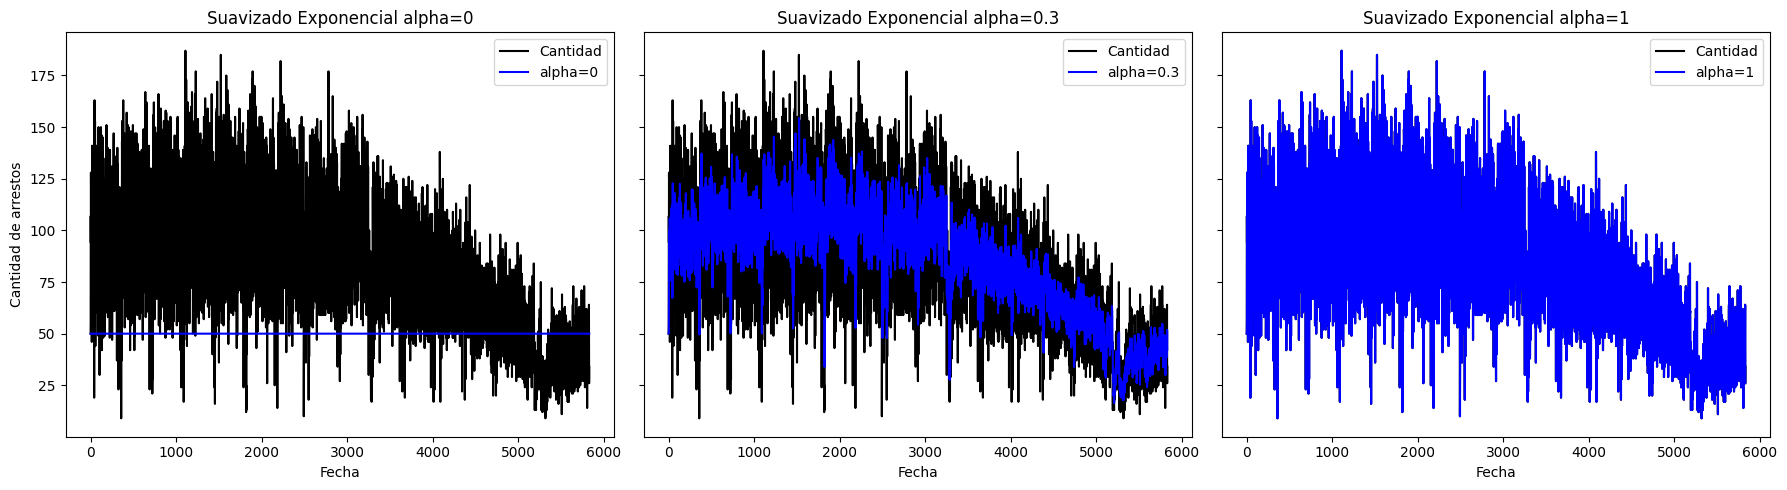

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Ajuste del modelo de suavizado exponencial simple con diferentes valores de alpha
model_exp_smoothing_0 = SimpleExpSmoothing(df_train['Cantidad']).fit(smoothing_level=0, optimized=False)
model_exp_smoothing_03 = SimpleExpSmoothing(df_train['Cantidad']).fit(smoothing_level=0.3, optimized=False)
model_exp_smoothing_1 = SimpleExpSmoothing(df_train['Cantidad']).fit(smoothing_level=1, optimized=False)

# Configurar los modelos en un diccionario para iterar fácilmente
models = {
    "alpha=0": model_exp_smoothing_0,
    "alpha=0.3": model_exp_smoothing_03,
    "alpha=1": model_exp_smoothing_1,
}

# Graficar cada modelo en un gráfico separado
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=True)

for ax, (alpha, model) in zip(axes, models.items()):
    df_train.plot(kind="line", y="Cantidad", color='black', ax=ax, title=f"Suavizado Exponencial {alpha}")
    model.fittedvalues.plot(ax=ax, label=alpha, color='blue')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Cantidad de arrestos')
    ax.legend()

plt.tight_layout()
plt.show()


Verificar si la serie es estacionaria o no

In [ ]:
#NO CORRE POR EL TIEMPO
from statsmodels.tsa.stattools import adfuller

# Seleccionar la columna de la serie de tiempo
series = data['Cantidad']  # Reemplaza 'Cantidad' con el nombre de tu columna
result = adfuller(series)  

KeyboardInterrupt: 

In [ ]:
#NO CORRE POR EL TIEMPO

# Mostrar los resultados
print('Estadístico ADF: %f' % result[0])
print('p-valor: %f' % result[1])
for key, value in result[4].items():
    print('Valor crítico %s: %.2f' % (key, value))

if result[1] <= 0.05:
    print("La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("La serie no es estacionaria (no se puede rechazar la hipótesis nula).")


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Gráficos de ACF y PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [ ]:
df_train, df_test = train_test_split(
    cantidad_por_dia, test_size=0.2, shuffle=False, random_state=42
)

# Convertir las columnas en series para trabajar con ARIMA
train = df_train['Cantidad'].values
test = df_test['Cantidad'].values

In [ ]:
# Modelo ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Ajustar el modelo ARIMA con parámetros específicos
model_ARIMA = ARIMA(train, order=(2, 1, 3))  # Cambia (2,1,3) según tus necesidades
results_ARIMA = model_ARIMA.fit()

# Resumen del modelo
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4675
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -30404.849
Date:                Sun, 24 Nov 2024   AIC                          60821.698
Time:                        17:49:15   BIC                          60860.397
Sample:                             0   HQIC                         60835.308
                               - 4675                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2471   5.45e-05   2.29e+04      0.000       1.247       1.247
ar.L2         -1.0000   1.39e-06  -7.19e+05      0.000      -1.000      -1.000
ma.L1         -2.0122      0.007   -280.418      0.0

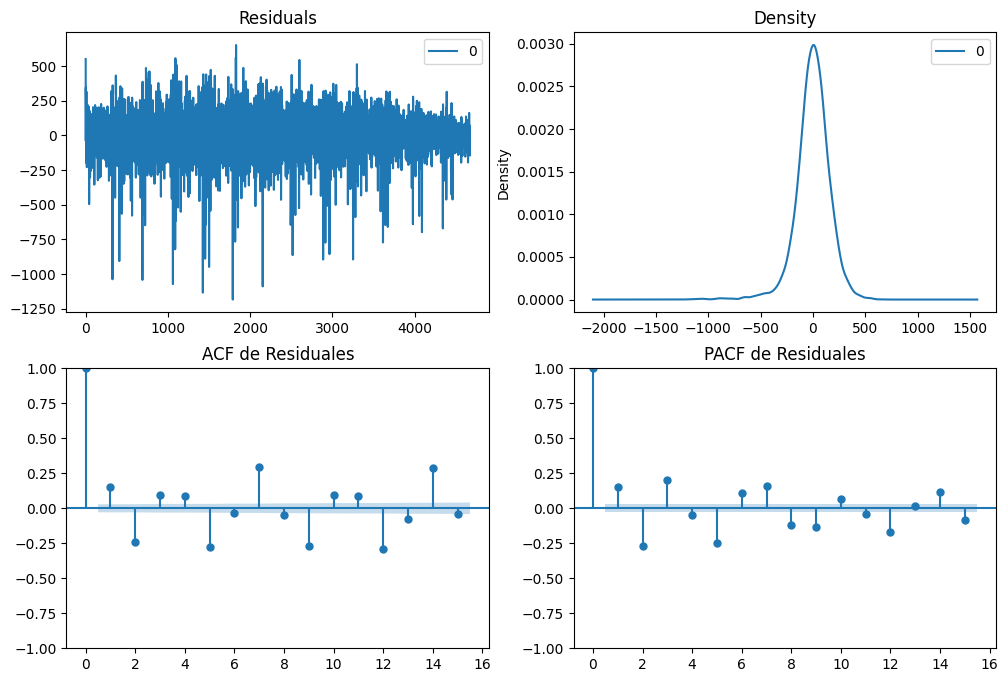

In [ ]:
# Análisis de residuales
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
residuals.plot(title="Residuals", ax=axes[0, 0])
residuals.plot(kind='kde', title='Density', ax=axes[0, 1])
plot_acf(residuals, lags=15, ax=axes[1, 0], title='ACF de Residuales')
plot_pacf(residuals, lags=15, ax=axes[1, 1], title='PACF de Residuales')
plt.show()

In [ ]:
# Entrenar y predecir usando una ventana deslizante
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 3))  # Usa el mismo orden que antes
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'predicted={yhat:.3f}, expected={obs:.3f}')


predicted=541.278, expected=546.000
predicted=491.008, expected=441.000
predicted=510.319, expected=608.000
predicted=660.917, expected=682.000
predicted=772.811, expected=733.000
predicted=780.669, expected=730.000
predicted=671.153, expected=636.000
predicted=531.912, expected=449.000
predicted=453.905, expected=500.000
predicted=524.138, expected=550.000
predicted=651.911, expected=653.000
predicted=753.285, expected=597.000
predicted=713.314, expected=881.000
predicted=663.483, expected=708.000
predicted=543.065, expected=499.000
predicted=468.538, expected=437.000
predicted=515.407, expected=464.000
predicted=630.591, expected=559.000
predicted=709.937, expected=778.000
predicted=733.949, expected=813.000
predicted=666.346, expected=595.000
predicted=518.053, expected=573.000
predicted=471.472, expected=468.000
predicted=521.514, expected=536.000
predicted=649.536, expected=664.000
predicted=755.443, expected=738.000
predicted=762.558, expected=557.000
predicted=608.703, expected=

Test RMSE: 72.772


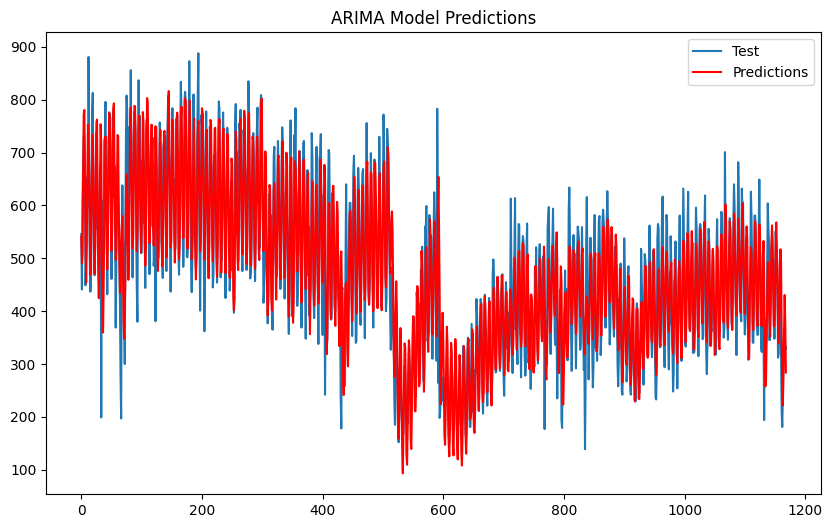

In [ ]:
# Evaluar el modelo con RMSE
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.plot(test, label='Test')
plt.plot(predictions, color='red', label='Predictions')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

In [ ]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 7.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Renombrar las columnas para que sean compatibles con Prophet
df_train = df_train.rename(columns={'Date': 'ds', 'Cantidad': 'y'})
df_test = df_test.rename(columns={'Date': 'ds', 'Cantidad': 'y'})

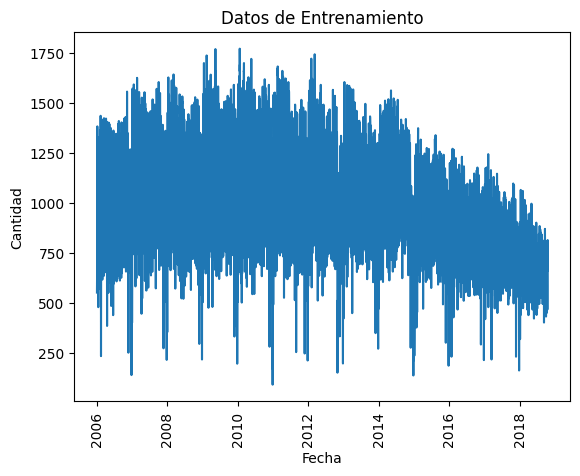

In [ ]:
# Visualizar los datos de entrenamiento
plt.plot(df_train['ds'], df_train['y'])
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.title('Datos de Entrenamiento')
plt.show()

In [ ]:
# Crear el modelo Prophet y ajustarlo
model = Prophet()
model.fit(df_train)


18:29:24 - cmdstanpy - INFO - Chain [1] start processing
18:29:24 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
pip install --upgrade prophet


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Crear un DataFrame para el futuro
future = model.make_future_dataframe(periods=365)

# Hacer las predicciones
forecast = model.predict(future)


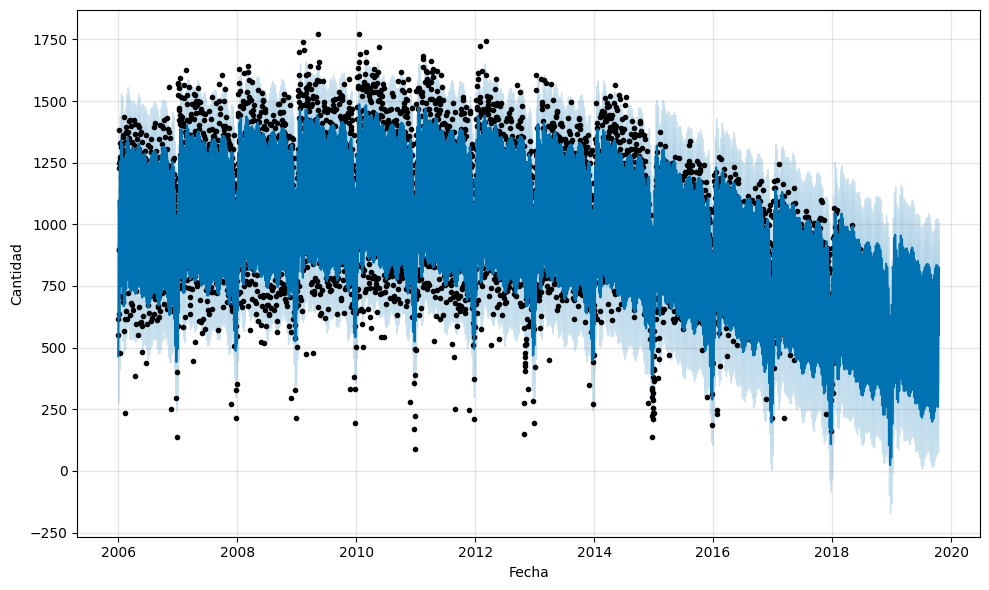

In [ ]:
# Visualizar las predicciones
model.plot(forecast)
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.show()

In [ ]:
# Evaluación del modelo en el conjunto de prueba
forecast = model.predict(df_test)
rmse = sqrt(mean_squared_error(df_test['y'], forecast['yhat'][-len(df_test):]))
print(f'RMSE: {round(rmse,2)}')



RMSE: 188.92


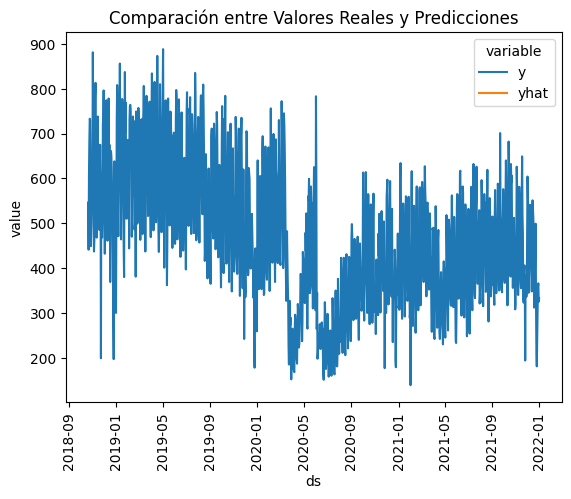

In [ ]:
# Opcional: Visualizar los resultados de la predicción
import seaborn as sns
aux = df_test.copy()
aux['yhat'] = forecast['yhat']
aux = pd.melt(aux, id_vars=['ds'], value_vars=['y', 'yhat'])

sns.lineplot(x=aux.ds, y=aux.value, hue=aux.variable)
plt.xticks(rotation=90)
plt.title('Comparación entre Valores Reales y Predicciones')
plt.show()

In [ ]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


Falta agregar modelos con regresores
Falta test de estacionalidad. Eso condiciona hiperparametros del ARIMA